In [1]:
pip install torch numpy pandas scikit-learn tensorflow shap scikit-optimize openpyxl numpy matplotlib scikit-learn scipy tensorflow boruta


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from BTC_helper import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skopt import BayesSearchCV
import shap

In [56]:
#upload dependency files from E:\objective 3_code
binance_file_merged="/content/Binance_data_combined_v2_merged.xlsx"
coinbase_file_merged="/content/Coinbase_data_combined_v2_merged.xlsx"
kraken_file_merged="/content/Kraken_data_combined_v2_merged.xlsx"

# Load merged data from excel files into DataFrames
kraken_data = pd.read_excel(kraken_file_merged, index_col=[0, 1])
coinbase_data = pd.read_excel(coinbase_file_merged, index_col=[0, 1])
binance_data = pd.read_excel(binance_file_merged, index_col=[0, 1])
print("Binance Data\n",binance_data.tail(3))
#print("Kraken Data\n",kraken_data.tail(3))
#print("Coinbase Data\n",coinbase_data.tail(3))



Binance Data
                      open      high       low     close        volume  \
Coin Date                                                               
XRP  2023-04-18  0.514158  0.516034  0.501757  0.499401  9.488975e+08   
     2023-04-19  0.504747  0.508703  0.487858  0.488230  1.174681e+09   
     2023-04-20  0.491520  0.498827  0.468671  0.474858  1.484252e+09   

                 github_commits  google_trends  tweets      VWAP  \
Coin Date                                                          
XRP  2023-04-18             1.0             64   10932  0.682851   
     2023-04-19             1.0             74   10980  0.682807   
     2023-04-20             1.0             58   10971  0.682747   

                          OBV  ...        ADX      MACD  MACD_signal  \
Coin Date                      ...                                     
XRP  2023-04-18  3.996385e+11  ...  46.576025  0.016458     0.022590   
     2023-04-19  3.984638e+11  ...  43.825070  0.013340     0.0

In [57]:
# Reset the indices of the dataframes
kraken_data_reset = kraken_data.reset_index()
coinbase_data_reset = coinbase_data.reset_index()
binance_data_reset = binance_data.reset_index()

# Concatenate the reset dataframes
combined_data = pd.concat([kraken_data_reset, coinbase_data_reset, binance_data_reset])

# Calculate the average 'close' price for each coin at each timestamp across all exchanges
average_prices = combined_data.groupby(['Date', 'Coin'])['close'].mean()

# Function to calculate price inconsistency
def calculate_price_inconsistency(data):
    # Reset the index of the data
    data_reset = data.reset_index()
    # Map the average prices to the data
    data_reset['average_price'] = data_reset.set_index(['Date', 'Coin']).index.map(average_prices)
    # Calculate the price inconsistency for each row as the absolute difference between the 'close' price and the average 'close' price
    data_reset['price_inconsistency'] = np.abs(data_reset['close'] - data_reset['average_price'])
    # Set the index back to ['Date', 'Coin']
    data_final = data_reset.set_index(['Date', 'Coin'])
    return data_final

# Apply the function to each dataframe
kraken_data_full = calculate_price_inconsistency(kraken_data)
coinbase_data_full = calculate_price_inconsistency(coinbase_data)
binance_data_full = calculate_price_inconsistency(binance_data)



# One-hot encode the Coin column to create separate columns for each coin
kraken_data_encoded = pd.get_dummies(kraken_data_full.reset_index(level='Coin'), columns=['Coin']).sort_index()
coinbase_data_encoded= pd.get_dummies(coinbase_data_full.reset_index(level='Coin'), columns=['Coin']).sort_index()
binance_data_encoded= pd.get_dummies(binance_data_full.reset_index(level='Coin'), columns=['Coin']).sort_index()
print(binance_data_encoded)
#binance_data_encoded.to_csv("binance_data_full.csv")
binance_data_encoded

                   open         high          low        close        volume  \
Date                                                                           
2017-01-01   961.974294   964.792136   942.240444   965.202234  1.164446e+08   
2017-01-01     4.617368     4.674184     4.470000     4.583671  1.246421e+07   
2017-01-01     0.006239     0.006392     0.006263     0.006374  1.084780e+06   
2017-01-01     8.566456     8.964149     8.317667     8.796849  1.797008e+07   
2017-01-01    11.589936    12.810720    11.426954    12.656489  4.085362e+06   
...                 ...          ...          ...          ...           ...   
2023-04-20  2058.651219  2028.816640  1955.785571  1940.088415  9.466329e+09   
2023-04-20    90.435072    91.883534    87.580449    90.239658  7.477496e+08   
2023-04-20    53.092521    53.497630    51.117428    51.672520  9.171417e+07   
2023-04-20     0.491520     0.498827     0.468671     0.474858  1.484252e+09   
2023-04-21  1943.409924  1955.649121  18

,open,high,low,close,volume,github_commits,google_trends,tweets,VWAP,OBV,...,Transaction Fee,AML_KYC_required,bid_ask_spread,average_price,price_inconsistency,Coin_BTC,Coin_DASH,Coin_ETH,Coin_LTC,Coin_XRP
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,961.974294,964.792136,942.240444,965.202234,1.164446e+08,1.3,0,21071,509.758590,6.770451e+09,...,0.001,1.0,0.023651,979.076117,13.873883,1,0,0,0,0
2017-01-01,4.617368,4.674184,4.470000,4.583671,1.246421e+07,1.0,0,296,9.281211,-5.056361e+08,...,0.001,1.0,0.044659,4.506835,0.076835,0,0,0,1,0
2017-01-01,0.006239,0.006392,0.006263,0.006374,1.084780e+06,1.0,0,5364,0.009341,-1.020175e+08,...,0.001,1.0,0.020277,0.006374,0.000000,0,0,0,0,1
2017-01-01,8.566456,8.964149,8.317667,8.796849,1.797008e+07,1.0,0,1791,11.470200,-4.066507e+08,...,0.001,1.0,0.074816,8.488424,0.308424,0,0,1,0,0
2017-01-01,11.589936,12.810720,11.426954,12.656489,4.085362e+06,8.0,0,2,8.333886,4.248272e+07,...,0.001,1.0,0.114183,12.656489,0.000000,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-20,2058.651219,2028.816640,1955.785571,1940.088415,9.466329e+09,5.0,74,24423,1662.408598,2.024278e+12,...,0.001,1.0,0.036657,1941.624208,1.535792,0,0,1,0,0
2023-04-20,90.435072,91.883534,87.580449,90.239658,7.477496e+08,1.0,58,889,120.772130,5.257955e+11,...,0.001,1.0,0.047955,90.249829,0.010171,0,0,0,1,0
2023-04-20,53.092521,53.497630,51.117428,51.672520,9.171417e+07,2.0,58,249,163.957796,6.776757e+10,...,0.001,1.0,0.045504,51.661260,0.011260,0,1,0,0,0


In [58]:
# Function to handle missing data and print missing values
def handle_missing_data(df, exchange_name):
    num_missing = df.isnull().sum()
    missing_values = num_missing[num_missing > 0]
    print(f'Initial missing values in {exchange_name} data:')
    print(missing_values)
    
    total_nans = num_missing.sum()
    print(f'Total number of NaN values in the DataFrame: {total_nans}')
    
    df = df.fillna(method='bfill')
    df = df.fillna(method='ffill')
    
    num_missing = df.isnull().sum()
    missing_values = num_missing[num_missing > 0]
    print(f'Missing values in {exchange_name} data after handling missing data:')
    print(missing_values)
    
    total_nans = num_missing.sum()
    print(f'Total number of NaN values in the DataFrame after handling missing data: {total_nans}')
    
    return df

# Apply the function to each dataframe
kraken_data_encoded = handle_missing_data(kraken_data_encoded, 'Kraken')
coinbase_data_encoded = handle_missing_data(coinbase_data_encoded, 'Coinbase')
binance_data_encoded = handle_missing_data(binance_data_encoded, 'Binance')
#binance_data_encoded.to_csv("binance_data_encoded.csv")

Initial missing values in Kraken data:
Series([], dtype: int64)
Total number of NaN values in the DataFrame: 0
Missing values in Kraken data after handling missing data:
Series([], dtype: int64)
Total number of NaN values in the DataFrame after handling missing data: 0
Initial missing values in Coinbase data:
Series([], dtype: int64)
Total number of NaN values in the DataFrame: 0
Missing values in Coinbase data after handling missing data:
Series([], dtype: int64)
Total number of NaN values in the DataFrame after handling missing data: 0
Initial missing values in Binance data:
Maker Fee           1
Transaction Fee     1
AML_KYC_required    1
dtype: int64
Total number of NaN values in the DataFrame: 3
Missing values in Binance data after handling missing data:
Series([], dtype: int64)
Total number of NaN values in the DataFrame after handling missing data: 0


In [59]:
from scipy.signal import savgol_filter
##########################OUTLIER TREATMENT ####################################

def outlier_treatment(data, exchange_name):
    # Copy data for processing
    data_copy = data.copy()

    # Get column names
    col_names_reduced = [column for column in data_copy]

    # Apply Hampel filter to detect outliers and impute with rolling median
    df_outliers_removed = hampel_filter_data(data_copy, col_names_reduced, 15, True)

    # Apply Savgol filter to reduce noise in the timeseries
    df_reduced_smooth = df_outliers_removed.copy()
    df_reduced_smooth = savgol_filter_data(df_reduced_smooth, col_names_reduced, window_size=52, polynomial_degree=1)

    # Convert the specified columns to integer values
    cols_to_convert = ['AML_KYC_required','Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP']
    df_reduced_smooth[cols_to_convert] = df_reduced_smooth[cols_to_convert].astype(int)
    
    print(f'{exchange_name} Data Shape after Outlier Treatment:', df_reduced_smooth.shape)
    
    return df_reduced_smooth


# Apply the function to each dataframe
kraken_data_encoded_reduced_smooth = outlier_treatment(kraken_data_encoded, 'Kraken')
coinbase_data_encoded_reduced_smooth = outlier_treatment(coinbase_data_encoded, 'Coinbase')
binance_data_encoded_reduced_smooth = outlier_treatment(binance_data_encoded, 'Binance')


Kraken Data Shape after Outlier Treatment: (11455, 28)
Coinbase Data Shape after Outlier Treatment: (9144, 28)
Binance Data Shape after Outlier Treatment: (11504, 28)


# **#Preload the preprocessed data**

In [60]:
kraken_data_encoded_reduced_smooth.to_csv("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth.to_csv("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth.to_csv("binance_data_encoded_reduced_smooth.csv")

In [3]:

kraken_data_encoded_reduced_smooth = pd.read_csv("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth = pd.read_csv("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth = pd.read_csv("binance_data_encoded_reduced_smooth.csv")


In [4]:
def prepare_data(df, model_type):
    # Separate the dependent and independent variables
    X = df.drop('price_inconsistency', axis=1)
    y = df['price_inconsistency']

    # Split the data into training + validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Then split the training + validation set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler on the training data
    scaler.fit(X_train)

    # Transform the training, validation, and test data
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the input data to fit the CNN-BiLSTM model (samples, time steps, features)
    if model_type == 'CNN-BiLSTM':
        X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_val_scaled = np.reshape(X_val_scaled, (X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
        X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


def load_date_to_index(file_path):
    df = pd.read_csv(file_path) # Load the csv file
    df['Date'] = pd.to_datetime(df['Date']) # Convert the 'Date' column to datetime format
    # Set the 'Date' column as the index
    df.set_index('Date', inplace=True)
    return df

# Load the preprocessed csv files
kraken_data_encoded_reduced_smooth = pd.read_csv("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth = pd.read_csv("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth = pd.read_csv("binance_data_encoded_reduced_smooth.csv")

# Load and prepare the data
kraken_data_encoded_reduced_smooth = load_date_to_index("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth = load_date_to_index("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth = load_date_to_index("binance_data_encoded_reduced_smooth.csv")

features_to_include=['github_commits',
       'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI', 'ADX', 'MACD',
       'MACD_signal', 'MACD_hist', 'RSI', 'WilliamsR', 'Maker Fee',
       'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
        'price_inconsistency', 'Coin_BTC', 'Coin_DASH',
       'Coin_ETH', 'Coin_LTC', 'Coin_XRP']
kraken_data_encoded_reduced_smooth= kraken_data_encoded_reduced_smooth[features_to_include]       
coinbase_data_encoded_reduced_smooth=coinbase_data_encoded_reduced_smooth[features_to_include]
binance_data_encoded_reduced_smooth=binance_data_encoded_reduced_smooth[features_to_include]

# Prepare the data
kraken_X_train_scaled, kraken_X_val_scaled, kraken_X_test_scaled, kraken_y_train, kraken_y_val, kraken_y_test = prepare_data(kraken_data_encoded_reduced_smooth,"")
coinbase_X_train_scaled, coinbase_X_val_scaled, coinbase_X_test_scaled, coinbase_y_train, coinbase_y_val, coinbase_y_test = prepare_data(coinbase_data_encoded_reduced_smooth,"")
binance_X_train_scaled, binance_X_val_scaled, binance_X_test_scaled, binance_y_train, binance_y_val, binance_y_test = prepare_data(binance_data_encoded_reduced_smooth,"")

print("Kraken data")
print(kraken_X_train_scaled.shape)
print(kraken_X_val_scaled.shape)
print(kraken_X_test_scaled.shape)

print("")
print("Coinbase data")
print(coinbase_X_train_scaled.shape)
print(coinbase_X_val_scaled.shape)
print(coinbase_X_test_scaled.shape)

print("")
print("Binance data")
print(binance_X_train_scaled.shape)
print(binance_X_val_scaled.shape)
print(binance_X_test_scaled.shape)


Kraken data
(6873, 21)
(2291, 21)
(2291, 21)

Coinbase data
(5486, 21)
(1829, 21)
(1829, 21)

Binance data
(6902, 21)
(2301, 21)
(2301, 21)


In [5]:


print("Kraken data")
print(kraken_data_encoded_reduced_smooth.columns)
print("")
print("Coinbase data")
print(coinbase_data_encoded_reduced_smooth.columns)
print("")
print("Binance data")
print(binance_data_encoded_reduced_smooth.columns)
print(binance_data_encoded_reduced_smooth.shape)

Kraken data
Index(['github_commits', 'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI',
       'ADX', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'price_inconsistency', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP'],
      dtype='object')

Coinbase data
Index(['github_commits', 'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI',
       'ADX', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'price_inconsistency', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP'],
      dtype='object')

Binance data
Index(['github_commits', 'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI',
       'ADX', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'price_inconsistency', 'Coin_BTC', 'Coin_DASH',

# Train LightGBM Model for each exchange

In [6]:
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def train_model(X_train_scaled, y_train, X_test_scaled):
    # Create a LightGBM regressor
    lgbm = lgb.LGBMRegressor()

    # Define the hyperparameter search space
    search_space = {
        'learning_rate': Real(0.01, 1.0),
        'n_estimators': Integer(10, 1000),
        'num_leaves': Integer(2, 100),
        'min_child_samples': Integer(1, 100),
        'subsample': Real(0.1, 1.0),
        'colsample_bytree': Real(0.1, 1.0)
    }
    
    opt = BayesSearchCV(lgbm, search_space, n_iter=32) # Create a BayesSearchCV object
    opt.fit(X_train_scaled, y_train) # Fit the optimizer on the training data
    print(opt.best_params_) # Print the best hyperparameters

    # Make predictions on the Train and test data using the best model
    y_train_pred = opt.predict(X_train_scaled)
    y_test_pred = opt.predict(X_test_scaled)
    return y_train_pred, y_test_pred, opt


In [7]:
# Prepare and train model on Kraken data
print("Training model on Kraken data..")
kraken_y_train_pred, kraken_y_test_pred,kraken_opt = train_model(kraken_X_train_scaled, kraken_y_train, kraken_X_test_scaled)
print("Model training complete")

Training model on Kraken data..
OrderedDict([('colsample_bytree', 0.6683030204679138), ('learning_rate', 0.6782959074621998), ('min_child_samples', 2), ('n_estimators', 1000), ('num_leaves', 89), ('subsample', 0.39317732374664305)])
Model training complete


In [8]:
# Prepare and train model on Coinbase data
print("Training model on Coinbase data..")
coinbase_y_train_pred, coinbase_y_test_pred,conibase_opt = train_model(coinbase_X_train_scaled, coinbase_y_train, coinbase_X_test_scaled)
print("Model training complete")


Training model on Coinbase data..
OrderedDict([('colsample_bytree', 0.9121714889747318), ('learning_rate', 0.08016200310103636), ('min_child_samples', 31), ('n_estimators', 81), ('num_leaves', 18), ('subsample', 1.0)])
Model training complete


In [9]:
# Prepare and train model on Binance data
print("Training model on Binance data..")
binance_y_train_pred, binance_y_test_pred, binance_opt = train_model(binance_X_train_scaled, binance_y_train, binance_X_test_scaled)
print("Model training complete")

Training model on Binance data..
OrderedDict([('colsample_bytree', 0.37973334257913016), ('learning_rate', 0.48932142872550183), ('min_child_samples', 1), ('n_estimators', 811), ('num_leaves', 59), ('subsample', 0.7324336948873252)])
Model training complete


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def calculate_metrics(y_train, y_train_pred, y_test, y_test_pred):
    # Calculate the training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

    # Calculate the test metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    # Print the training and test metrics
    print(f'Training RMSE: {train_rmse:.4f}')
    print(f'Training MAE: {train_mae:.4f}')
    print(f'Training MAPE: {train_mape:.4f}%')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')
    print(f'Test MAPE: {test_mape:.4f}%')

# Calculate and print metrics for Kraken
print("METRICS FOR KRAKEN:")
calculate_metrics(kraken_y_train, kraken_y_train_pred, kraken_y_test, kraken_y_test_pred)
print("\n")
print("METRICS FOR COINBASE:")
calculate_metrics(coinbase_y_train, coinbase_y_train_pred, coinbase_y_test, coinbase_y_test_pred)
print("\n")
print("METRICS FOR BINANCE:")
calculate_metrics(binance_y_train, binance_y_train_pred, binance_y_test, binance_y_test_pred)


METRICS FOR KRAKEN:
Training RMSE: 0.0000
Training MAE: 0.0000
Training MAPE: 0.0000%
Test RMSE: 0.9290
Test MAE: 0.7383
Test MAPE: 0.5747%


METRICS FOR COINBASE:
Training RMSE: 0.2230
Training MAE: 0.1542
Training MAPE: 0.0983%
Test RMSE: 10.2683
Test MAE: 6.7983
Test MAPE: 2.2512%


METRICS FOR BINANCE:
Training RMSE: 0.0000
Training MAE: 0.0000
Training MAPE: 0.0000%
Test RMSE: 0.9368
Test MAE: 0.6629
Test MAPE: 0.6230%


#RUN SHAP ANALYSIS for each exchange

In [11]:
import shap
import matplotlib.pyplot as plt

# Modify the explainer creation for each model
kraken_explainer = shap.Explainer(kraken_opt.best_estimator_)
coinbase_explainer = shap.Explainer(conibase_opt.best_estimator_)
binance_explainer = shap.Explainer(binance_opt.best_estimator_)

def plot_summary(shap_values, feature_names):
    print("Plotting SHAP summary...")
    shap.summary_plot(shap_values, feature_names=feature_names)

def plot_local_importance(explainer, observation, feature_names):
    print("Plotting local feature importance...")
    shap_values = explainer(observation)
    shap.force_plot(explainer.expected_value, shap_values.values, observation, feature_names=feature_names)

def run_shap_analysis(explainer, X_data, feature_names, observation_indices):
    print("Running SHAP analysis...")

    # Calculate the SHAP values for the test data
    shap_values = explainer(X_data)

    plot_summary(shap_values, X_data, feature_names)
    plot_global_importance(shap_values)

    feature_importance_df = generate_importance_df(shap_values, X_data, feature_names)
    feature_importance_df.to_csv('feature_importance.csv', index=False)

    for obs_index in observation_indices:
        observation = X_data[obs_index]
        observation = observation.reshape(1, -1)
        plot_local_importance(explainer, observation, feature_names)

In [12]:


# Calculate SHAP values for each model
kraken_shap_values = kraken_explainer.shap_values(kraken_X_test_scaled)
coinbase_shap_values = coinbase_explainer.shap_values(coinbase_X_test_scaled)
binance_shap_values = binance_explainer.shap_values(binance_X_test_scaled)


In [142]:
print(type(binance_shap_values))

<class 'numpy.ndarray'>


Running Global Feature Importance SHAP analysis for Kraken...




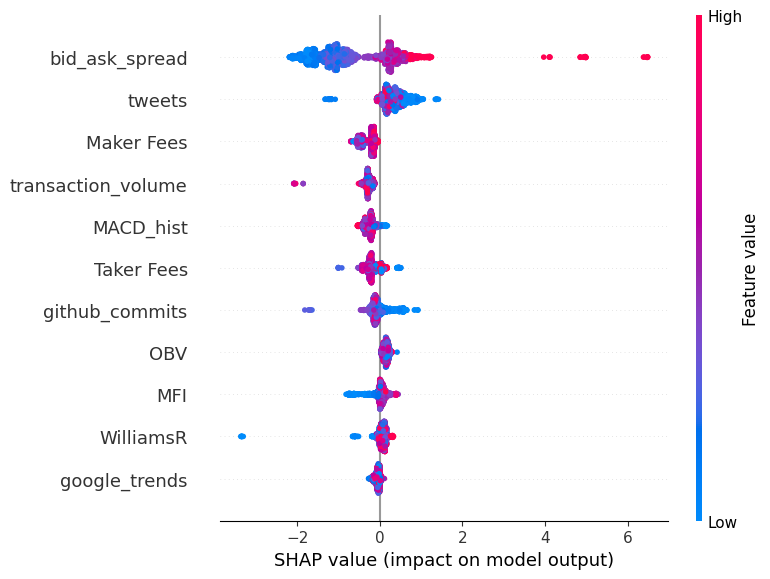

Running Global Feature Importance SHAP analysis for Coinbase...


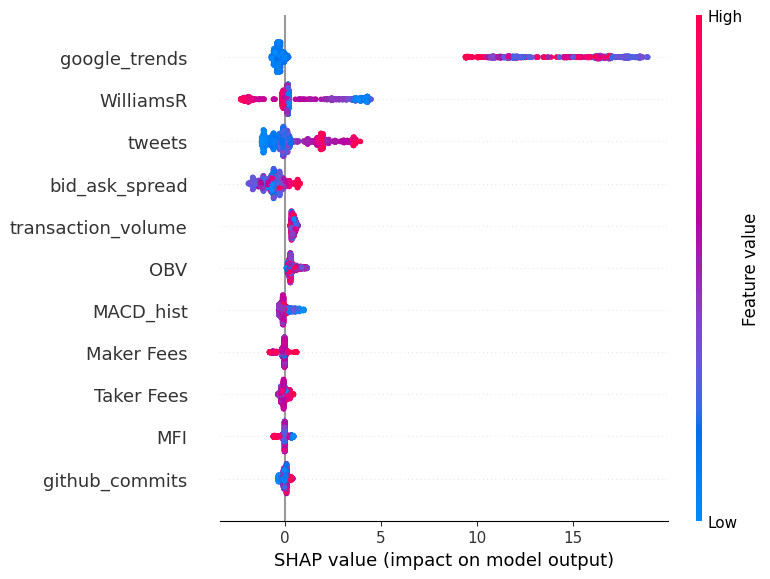



Running Global Feature Importance SHAP analysis for Binance...


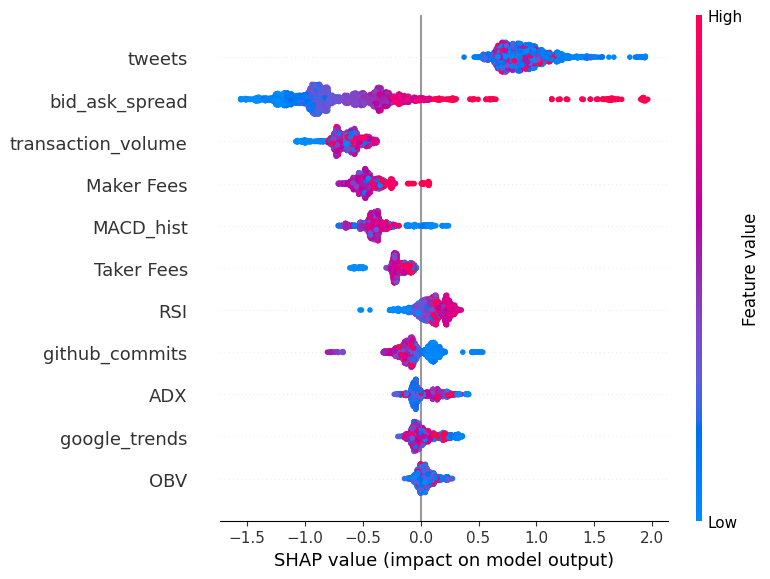

In [23]:
# Get indices of columns to remove
new_feature_names=['github_commits',
       'google_trends', 'tweets', 'transaction_volume', 'OBV', 'MFI', 'ADX', 'Maker Fees',
       'Taker Fees', 'MACD_hist', 'RSI', 'WilliamsR', 'daily_active_addresses',
       'MACD_signal', 'AML_KYC_required', 'bid_ask_spread',
        'Coin_BTC', 'Coin_DASH',
       'Coin_ETH', 'VWAP', 'Coin_XRP']

print("Running Global Feature Importance SHAP analysis for Kraken...")
print("\n")
shap.summary_plot(kraken_shap_values, kraken_X_test_scaled, feature_names=new_feature_names,max_display=11)


print("Running Global Feature Importance SHAP analysis for Coinbase...")
shap.summary_plot(coinbase_shap_values, coinbase_X_test_scaled, feature_names=new_feature_names,max_display=11)
print("\n")

print("Running Global Feature Importance SHAP analysis for Binance...")
shap.summary_plot(binance_shap_values, binance_X_test_scaled, feature_names=new_feature_names,max_display=11)

In [26]:
import pandas as pd

# Create a function to calculate mean absolute SHAP values for each feature
def mean_abs_shap(shap_values, feature_names):
    shap_abs = np.abs(shap_values)
    return pd.Series(np.mean(shap_abs, axis=0), index=feature_names)

# Calculate mean absolute SHAP values for each exchange
kraken_mean_shap = mean_abs_shap(kraken_shap_values, new_feature_names)
coinbase_mean_shap = mean_abs_shap(coinbase_shap_values, new_feature_names)
binance_mean_shap = mean_abs_shap(binance_shap_values, new_feature_names)

# Create DataFrames to display the results
kraken_df = pd.DataFrame({'Feature': new_feature_names,
                          'Kraken': kraken_mean_shap})
coinbase_df = pd.DataFrame({'Feature': new_feature_names,
                            'Coinbase': coinbase_mean_shap})
binance_df = pd.DataFrame({'Feature': new_feature_names,
                           'Binance': binance_mean_shap})

# Sort the results by feature importance
kraken_df = kraken_df.sort_values(by='Kraken', ascending=False)
coinbase_df = coinbase_df.sort_values(by='Coinbase', ascending=False)
binance_df = binance_df.sort_values(by='Binance', ascending=False)

# Display the results
print("Kraken Feature Importances:")
print(kraken_df)
print("\nCoinbase Feature Importances:")
print(coinbase_df)
print("\nBinance Feature Importances:")
print(binance_df)


Kraken Feature Importances:
                                       Feature    Kraken
bid_ask_spread                  bid_ask_spread  0.984009
tweets                                  tweets  0.380257
Maker Fees                          Maker Fees  0.302854
transaction_volume          transaction_volume  0.283336
MACD_hist                            MACD_hist  0.248029
Taker Fees                          Taker Fees  0.214803
github_commits                  github_commits  0.165028
OBV                                        OBV  0.148504
MFI                                        MFI  0.112933
WilliamsR                            WilliamsR  0.095812
google_trends                    google_trends  0.058216
RSI                                        RSI  0.049210
ADX                                        ADX  0.024638
daily_active_addresses  daily_active_addresses  0.000000
MACD_signal                        MACD_signal  0.000000
AML_KYC_required              AML_KYC_required  0.000000
Coi

array([[3.35609935e-01, 1.03503334e+01, 1.66955128e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.36470969e-01, 1.04147746e+01, 1.61301981e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.36532877e-01, 1.04131398e+01, 1.61206602e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.27355940e-03, 6.96209961e-01, 1.08415004e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.48229372e-03, 6.97120913e-01, 1.08536895e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.87799280e-03, 6.96046805e-01, 1.08532308e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

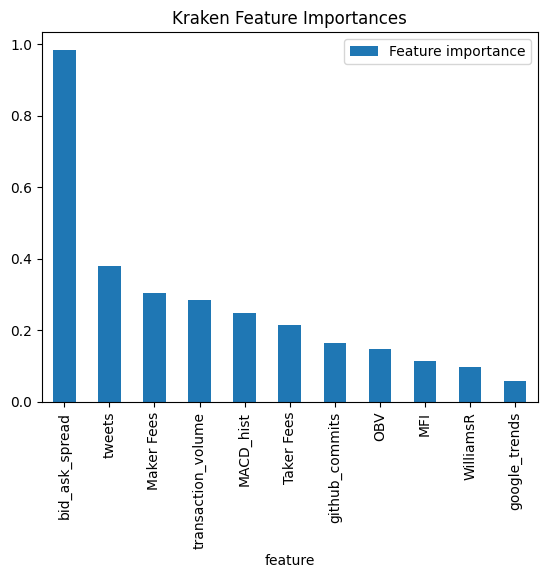

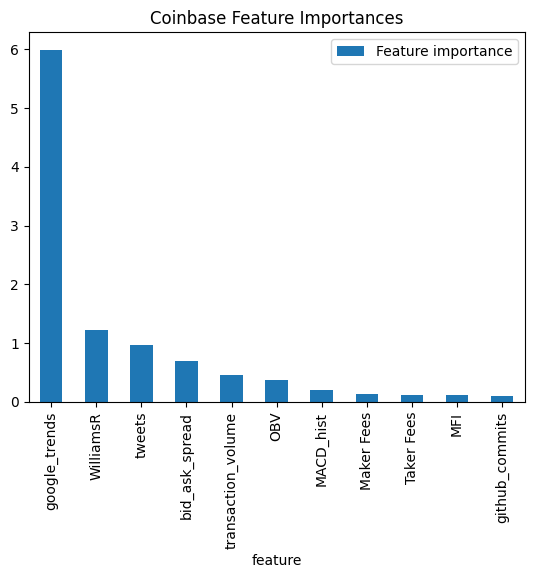

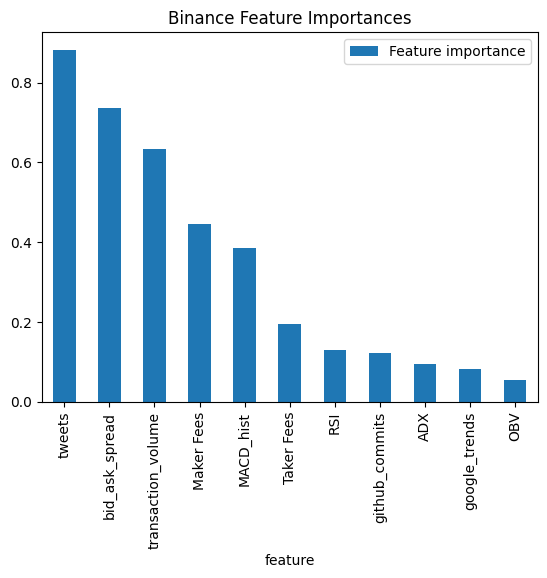

In [28]:
# Calculate mean absolute SHAP values for each feature
kraken_mean_shap_values = np.abs(kraken_shap_values).mean(axis=0)
coinbase_mean_shap_values = np.abs(coinbase_shap_values).mean(axis=0)
binance_mean_shap_values = np.abs(binance_shap_values).mean(axis=0)

# Create a DataFrame for each model to map features to their importances
kraken_importance_df = pd.DataFrame(list(zip(new_feature_names, kraken_mean_shap_values)), columns=['feature','Feature importance'])
coinbase_importance_df = pd.DataFrame(list(zip(new_feature_names, coinbase_mean_shap_values)), columns=['feature','Feature importance'])
binance_importance_df = pd.DataFrame(list(zip(new_feature_names, binance_mean_shap_values)), columns=['feature','Feature importance'])

# Sort the DataFrame by importance
kraken_importance_df = kraken_importance_df.sort_values(by='Feature importance', ascending=False)
coinbase_importance_df = coinbase_importance_df.sort_values(by='Feature importance', ascending=False)
binance_importance_df = binance_importance_df.sort_values(by='Feature importance', ascending=False)

# Plot bar charts
kraken_importance_df.head(11).plot(kind='bar', x='feature', y='Feature importance', title='Kraken Feature Importances')
coinbase_importance_df.head(11).plot(kind='bar', x='feature', y='Feature importance', title='Coinbase Feature Importances')
binance_importance_df.head(11).plot(kind='bar', x='feature', y='Feature importance', title='Binance Feature Importances')
plt.show()


In [136]:
# Modify the explainer creation for each model
kraken_explainer = shap.Explainer(kraken_opt.best_estimator_)
coinbase_explainer = shap.Explainer(conibase_opt.best_estimator_)
binance_explainer = shap.Explainer(binance_opt.best_estimator_)

numpy.ndarray

In [149]:
kraken_data_heatmap = kraken_data_encoded_reduced_smooth[['github_commits', 'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI',
       'ADX', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP']]


In [ ]:
# compute SHAP values
shap_values = kraken_explainer(kraken_data_heatmap)
shap.plots.heatmap(shap_values, max_display=14)
coinbase_data_heatmap = coinbase_data_encoded_reduced_smooth[['github_commits', 'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI',
       'ADX', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP']]
# compute SHAP values
coinbase_shap_values = coinbase_explainer(coinbase_data_heatmap)
shap.plots.heatmap(coinbase_shap_values, max_display=14)

binance_data_heatmap = binance_data_encoded_reduced_smooth[['github_commits', 'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI',
       'ADX', 'MACD', 'MACD_signal', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP']]
# compute SHAP values
binance_shap_values = coinbase_explainer(binance_data_heatmap)
shap.plots.heatmap(binance_shap_values, max_display=14)
